<a href="https://colab.research.google.com/github/WHU-Peter/COMP6248-Deep-Learning/blob/master/DL_lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Execute this code block to install dependencies when running on colab
try:
    import torch
except:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-1.0.0-{platform}-linux_x86_64.whl torchvision

try: 
    import torchbearer
except:
    !pip install torchbearer

import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchbearer
import matplotlib.pyplot as plt
import numpy as np

     |████████████████████████████████| 143kB 8.5MB/s 


In [35]:
# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)

# flatten 28*28 images to a 784 vector for each image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])

# load data
trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)

# create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

# define baseline model
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out

In [3]:
print(torch.cuda.get_device_name(0))
print(trainset.train_data.shape)
print(testset.test_data.shape)

GPU:0
no processes are running
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [8]:
from torchbearer import Callback
from torchbearer import callbacks
from torchbearer import Trial

device = "cuda:0" if torch.cuda.is_available() else "cpu"

@callbacks.on_end_epoch
def my_callback(state):
  Train_Loss[state[torchbearer.state.EPOCH]] = state[torchbearer.state.METRICS]['loss']
  Train_Acc[state[torchbearer.state.EPOCH]] = state[torchbearer.state.METRICS]['acc']
  Test_Loss[state[torchbearer.state.EPOCH]] = state[torchbearer.state.METRICS]['val_loss']
  Test_Acc[state[torchbearer.state.EPOCH]] = state[torchbearer.state.METRICS]['val_acc']

def train_model(model, epochs=100):
  model = model.to(device)
  # define the loss function and the optimiser
  loss_function = nn.CrossEntropyLoss()
  optimiser = optim.Adam(model.parameters())
  
  trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy'], callbacks=[my_callback]).to(device)
  trial.with_generators(trainloader, val_generator=testloader, test_generator=testloader)
  trial.run(epochs)

def plot():
  fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
  ax[0,0].plot(Train_Loss, c='m')
  ax[0,0].grid(True)
  ax[0,0].set_xlabel("Iteration", fontsize=14)
  ax[0,0].set_ylabel("Train_Loss", fontsize=14)
  ax[0,0].set_title("Traing Set", fontsize=14)
  ax[0,1].plot(Test_Loss, c='r')
  ax[0,1].grid(True)
  ax[0,1].set_xlabel("Iteration", fontsize=14)
  ax[0,1].set_ylabel("Test_Loss", fontsize=14)
  ax[0,1].set_title("Test Set", fontsize=14)
  ax[1,0].plot(Train_Acc, c='m')
  ax[1,0].grid(True)
  ax[1,0].set_xlabel("Iteration", fontsize=14)
  ax[1,0].set_ylabel("Train_Accuracy", fontsize=14)
  ax[1,0].set_title("Traing Set", fontsize=14)
  ax[1,1].plot(Test_Acc, c='r')
  ax[1,1].grid(True)
  ax[1,1].set_xlabel("Iteration", fontsize=14)
  ax[1,1].set_ylabel("Test_Accuracy", fontsize=14)
  ax[1,1].set_title("Test Set", fontsize=14)
  plt.show()

epo = 100

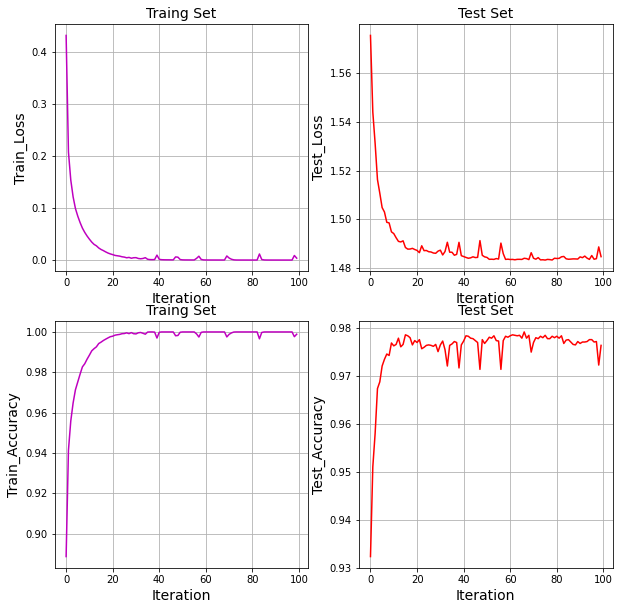

In [9]:
# 训练大约需要15分钟
Train_Loss = np.zeros(epo)
Train_Acc = np.zeros(epo)
Test_Loss = np.zeros(epo)
Test_Acc = np.zeros(epo)
model1 = BaselineModel(784, 100, 10)
train_model(model1, epochs=epo)
plot()

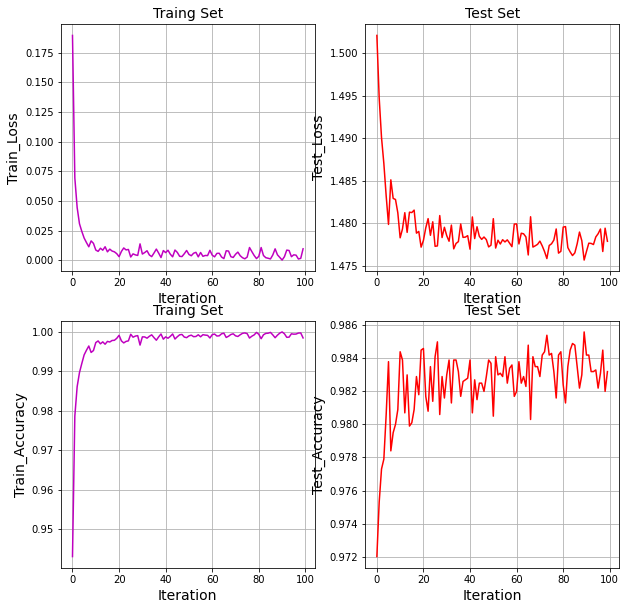

In [11]:
# 训练大概需要20分钟
Train_Loss = np.zeros(epo)
Train_Acc = np.zeros(epo)
Test_Loss = np.zeros(epo)
Test_Acc = np.zeros(epo)
model2 = BaselineModel(784, 10000, 10)
train_model(model2, epochs=epo)
plot()

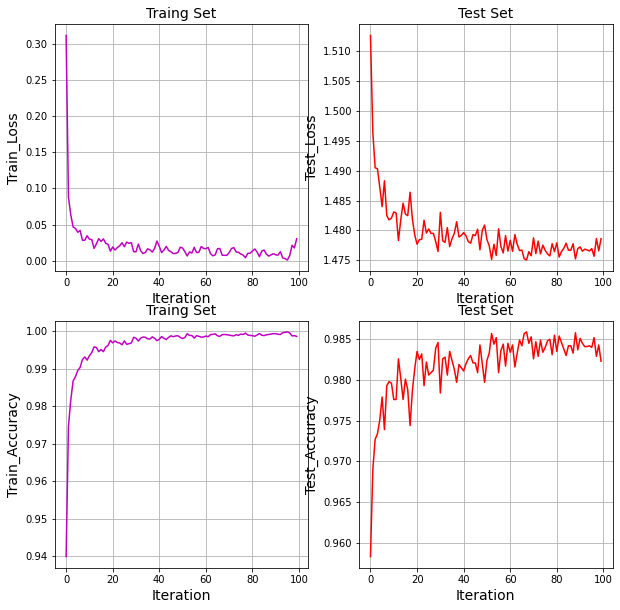

In [10]:
# 训练大约需要3.5小时
Train_Loss = np.zeros(epo)
Train_Acc = np.zeros(epo)
Test_Loss = np.zeros(epo)
Test_Acc = np.zeros(epo)
model3 = BaselineModel(784, 500000, 10)
train_model(model3, epochs=epo)
plot()

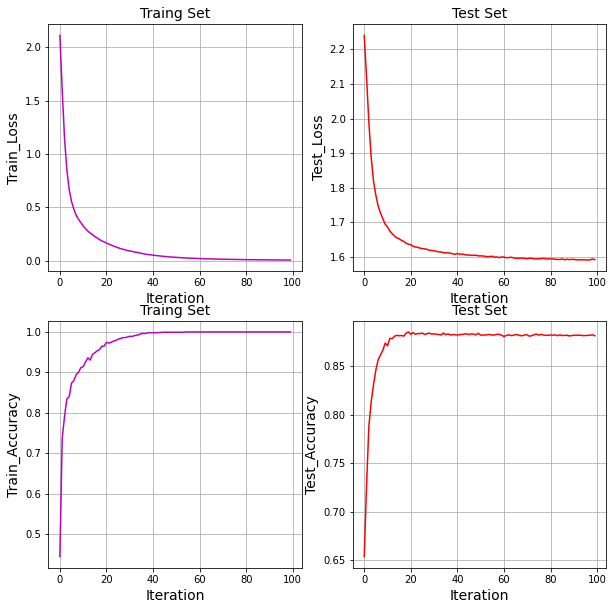

In [12]:
trainset.data = trainset.data[:1280]
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

Train_Loss = np.zeros(epo)
Train_Acc = np.zeros(epo)
Test_Loss = np.zeros(epo)
Test_Acc = np.zeros(epo)
model4 = BaselineModel(784, 100, 10)
train_model(model4, epochs=epo)
plot()